# Multi Instrument Example -- Sparse Matrix Method

## Setup AIA Inputs

### Import Statements

In [1]:
#%pip install astropy scipy ipympl ndcube xrtpy sunpy lxml drms zeep
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

from sys import path
import os, importlib, numpy as np, astropy.units as u, matplotlib as mpl, matplotlib.pyplot as plt
from astropy.time import Time
mpl.use("Agg")

# Enable interactive plotting with widgets
%matplotlib widget

# Set matplotlib parameters for better visualization
plt.rcParams.update({'image.origin': 'lower'})
np.set_printoptions(linewidth=128)

# Define base path and append EMToolKit path
base_path = os.getcwd(); path.append(base_path)

# import EMToolKit and its visualization module
import EMToolKit, EMToolKit.visualization.dashboard, EMToolKit.EMToolKit as emtk
from EMToolKit.instruments.xrt import xrt_wrapper
from EMToolKit.algorithms.sparse_matrix_dem_wrapper import sparse_matrix_dem_wrapper

# Initialize an empty EM collection
em_collection = 0

In [2]:
# These flags tell the program not to recalculate the data if it has already been calculated
redownload = False

### Download the Imagery

In [3]:
from EMToolKit.instruments.aia import download_sdo_data
from EMToolKit.instruments.xrt import download_xrt_data

date='2010-07-25T17:58:44'

# Download the data
aia_paths, sdo_data_dir = download_sdo_data(os.path.join(base_path,'data','2010-07-25T17_58_44'), date, redownload=redownload)
xrt_paths, xrt_data_dir = download_xrt_data(os.path.join(base_path,'data','2010-07-25T17_58_44'), date, redownload=redownload)
paths = aia_paths + xrt_paths

Found 6 AIA images on disk.
Found 0 xrt images on disk.
Searching for XRT images from 2010-07-25T17:58:44...


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

L1_XRT20100725_175844.2.fits:   0%|          | 0.00/4.21M [00:00<?, ?B/s]

### Load and Crop the Imagery

In [4]:
from EMToolKit.instruments.aia import load_from_paths, aia_wrapper

xl, yl, = 240*u.arcsec, -525*u.arcsec # Left edge of FOV in arcseconds (relative to disk center)
                                      # Right edge of FOV in arcseconds (relative to disk center)
xlen, ylen  = 270*u.arcsec, 240*u.arcsec # X size of FOV in arcseconds # Y size of FOV in arcseconds


# Load the AIA Images ###
aiamaps = load_from_paths(aia_paths,xl=xl,yl=yl,dx=xlen,dy=ylen)
temperature_array = np.arange(5.5, 7.5, 0.05)
[maps,errs,trlogts,tresps] = aia_wrapper(aiamaps, temperature_array=temperature_array)


# Load the XRT Image ###
    # We're loading these separately so that we can apply an offset to the XRT data -- there appears
    # to be a significant misalignment based on manual inspection and testing:
xrt_offsets = [-5*u.arcsec, -20*u.arcsec]
xrtmap = load_from_paths([[paths[0]],xrt_paths[0]],xl=xl+xrt_offsets[0],yl=yl+xrt_offsets[1],dx=xlen,dy=ylen)[1]
xrtmap.meta['crval1'] -= xrt_offsets[0].value
xrtmap.meta['crval2'] -= xrt_offsets[1].value
[xrtmaps,xrterrs,xrt_trlogts,xrt_tresps] = xrt_wrapper([xrtmap], temperature_array=temperature_array)

In [5]:
# # Append the XRT data to the AIA data
maps.append(xrtmaps[0])
errs.append(xrterrs[0])
trlogts.append(xrt_trlogts[0])
tresps.append(xrt_tresps[0])

In [6]:
# Make data sequence from AIA:
datasequence = emtk.em_data(maps,errs,trlogts,tresps)

# Create em_collection with data sequence:
em_collection = emtk.em_collection(datasequence)

In [7]:
# Normalizing the response functions makes them much easier for the solver to handle.
datmax_nominal = 1.0e4 # The nominal maximum of the data 
overall_norm = datmax_nominal/np.max(np.array(tresps))
norms = np.max(np.array(tresps),axis=0)/np.max(np.array(tresps))/overall_norm

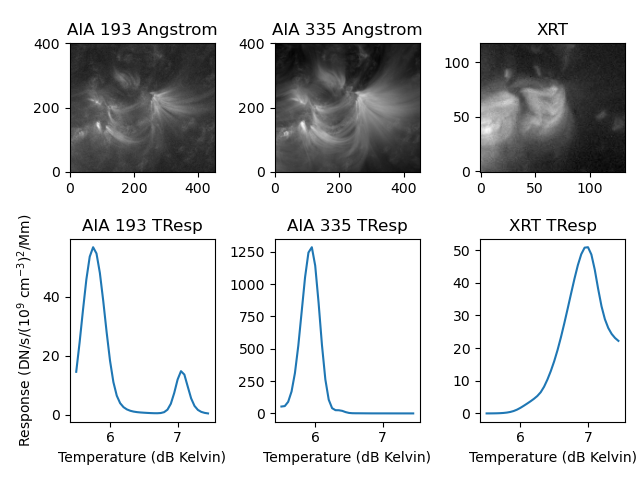

In [8]:
# Show some of the AIA channels and their temperature responses for illustration:

plt_emmax = 5.0e28  # Maximum emission value for plotting
gfac = 1.0 / 2.2  # Gamma correction factor for visualization

fig, axs = plt.subplots(2, 3)  # Create a figure with a 2x3 grid of subplots

# Plot AIA 193 Angstrom channel
axs[0, 0].imshow(np.clip(maps[1].data / np.max(tresps[1]), 0, plt_emmax) ** gfac, cmap=plt.get_cmap('gray'))
axs[0, 0].set(title='AIA 193 Angstrom')
axs[1, 0].plot(trlogts[1], tresps[1] / 1.0e-27)
axs[1, 0].set(title='AIA 193 TResp', xlabel='Temperature (dB Kelvin)', ylabel='Response (DN/s/(10$^9$ cm$^{-3})^2$/Mm)')

# Plot AIA 335 Angstrom channel
axs[0, 1].imshow(np.clip(maps[2].data / np.max(tresps[2]), 0, plt_emmax) ** gfac, cmap=plt.get_cmap('gray'))
axs[0, 1].set(title='AIA 335 Angstrom')
axs[1, 1].plot(trlogts[2], tresps[2] / 1.0e-27)
axs[1, 1].set(title='AIA 335 TResp', xlabel='Temperature (dB Kelvin)')

# Plot AIA 94 Angstrom channel
axs[0, 2].imshow(np.clip(maps[6].data / np.max(tresps[6]), 0, plt_emmax) ** gfac, cmap=plt.get_cmap('gray'))
axs[0, 2].set(title='XRT')
axs[1, 2].plot(trlogts[6], tresps[6] / 1.0e-27)
axs[1, 2].set(title='XRT TResp', xlabel='Temperature (dB Kelvin)')

# Adjust layout and show the plots
plt.tight_layout(); plt.show()

## DEM Analysis

### Compute the Differential Emission Measure

In [9]:
coeffs, logts, bases, wcs, name, alg_object = sparse_matrix_dem_wrapper(datasequence,wrapargs={'norms':norms, 'overall_norm':overall_norm})
matrix_multi_em_sequence = emtk.dem_model(coeffs, logts, bases, wcs, name, alg_object, meta=None)
em_collection.add_model(matrix_multi_em_sequence)

Computing forward matrix for data sequence element 1 of 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189010/189010 [01:41<00:00, 1859.68it/s]


Computing forward matrix for data sequence element 2 of 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189010/189010 [01:38<00:00, 1923.70it/s]


Computing forward matrix for data sequence element 3 of 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189010/189010 [01:39<00:00, 1897.04it/s]


Computing forward matrix for data sequence element 4 of 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189010/189010 [01:26<00:00, 2180.48it/s]


Computing forward matrix for data sequence element 5 of 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189010/189010 [01:28<00:00, 2135.65it/s]


Computing forward matrix for data sequence element 6 of 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189010/189010 [01:28<00:00, 2147.66it/s]


Computing forward matrix for data sequence element 7 of 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189010/189010 [01:28<00:00, 2140.52it/s]


69431.25898973951 1076.9306258570148 0.0 2.8913682762772446
Overall regularization factor: 1.0


Iteration:  10%|████████████████▏                                                                                                                                                 | 1/10 [01:11<10:42, 71.43s/it]

71.43 s i = 0 chi2 = 94.98 step size = 0.3 reg. param. = 0.11 chi2 change = 92.58234 reg. change = -0.11021
Setup:  0.6193864345550537 Solver:  67.24639987945557 Stepper:  3.566821336746216
New combined FOM: 95.09488869044529 Old combined FOM: 187.56702185154367 Change: 92.47213316109838


Iteration:  20%|████████████████████████████████▏                                                                                                                                | 2/10 [04:36<20:01, 150.15s/it]

276.69 s i = 1 chi2 = 20.69 step size = 0.85 reg. param. = 0.43 chi2 change = 74.29338 reg. change = -0.31571
Setup:  1.243659496307373 Solver:  269.0208535194397 Stepper:  6.420129299163818
New combined FOM: 21.117214328357086 Old combined FOM: 95.09488869044529 Change: 73.97767436208821


Iteration:  30%|████████████████████████████████████████████████▎                                                                                                                | 3/10 [08:53<23:12, 198.87s/it]

533.53 s i = 2 chi2 = 3.99 step size = 0.85 reg. param. = 0.63 chi2 change = 16.70236 reg. change = -0.2042
Setup:  1.66184663772583 Solver:  522.3231909275055 Stepper:  9.540129661560059
New combined FOM: 4.619056514216248 Old combined FOM: 21.117214328357086 Change: 16.49815781414084


Iteration:  40%|████████████████████████████████████████████████████████████████▍                                                                                                | 4/10 [12:37<20:51, 208.58s/it]

757.0 s i = 3 chi2 = 1.07 step size = 0.85 reg. param. = 0.69 chi2 change = 2.92148 reg. change = -0.05819
Setup:  2.09753155708313 Solver:  741.500129699707 Stepper:  13.399640083312988
New combined FOM: 1.7557602261100214 Old combined FOM: 4.619056514216248 Change: 2.8632962881062265


Iteration:  40%|████████████████████████████████████████████████████████████████▍                                                                                                | 4/10 [13:26<20:09, 201.65s/it]

806.59 s i = 4 chi2 = 0.85 step size = 0.85 reg. param. = 0.67 chi2 change = 0.2211 reg. change = 0.01347
Setup:  2.651094675064087 Solver:  786.8818175792694 Stepper:  17.047356128692627
New combined FOM: 1.521193047001699 Old combined FOM: 1.7557602261100214 Change: 0.23456717910832237


### Run the Dashboard

In [10]:
# Get the most recent version from the tool kit:
importlib.reload(EMToolKit.visualization.dashboard)
from EMToolKit.visualization.dashboard import dashboard_object

# Suppress specific SunpyMetadataWarning
import warnings
from sunpy.util.exceptions import SunpyMetadataWarning
warnings.filterwarnings("ignore", category=SunpyMetadataWarning)

Output()

Click on the image to populate the dashboard


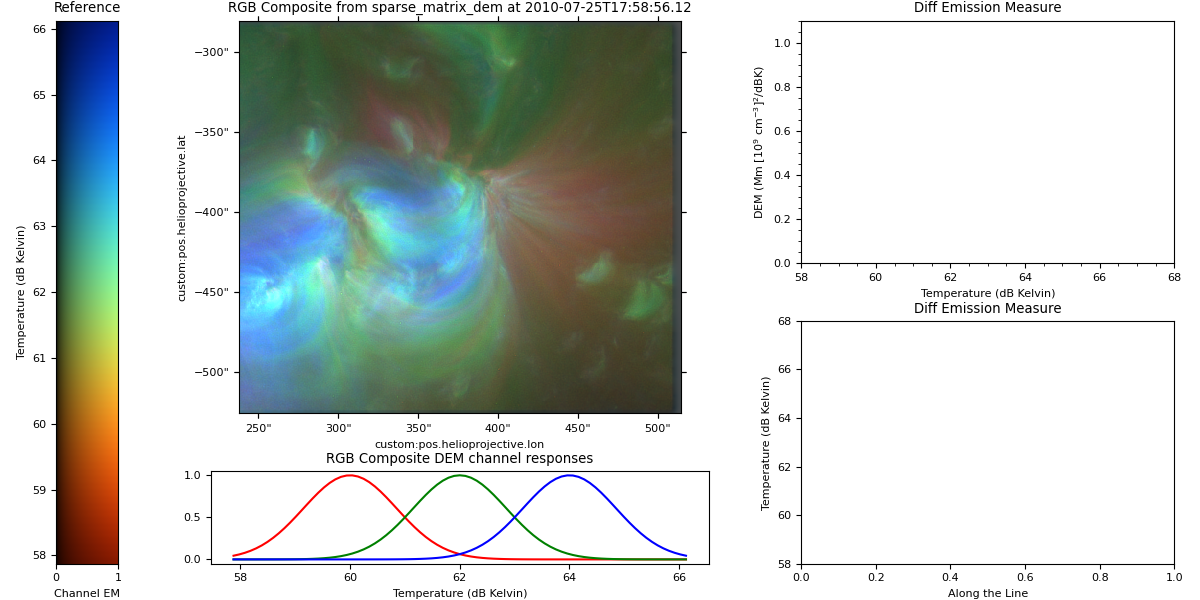

In [11]:
# Create the dashboard:
dash = dashboard_object(em_collection, xsize=12, ysize=6, fontsize=8)
dash.display(True)